In [1]:
import mediapipe as mp
import numpy as np
import pandas as pd
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

from custom_pose_landmarks import CustomPoseLandmark

In [2]:
mp_drawing = solutions.drawing_utils
mp_pose = solutions.pose

custom = CustomPoseLandmark(mp_pose)

In [52]:
def prepare_dataframe():
    axes = ['X', 'Y', 'Z']
    names = custom.get_landmarks().values()
    column_names = [('_'.join([name, axis])).lower() for name in names for axis in axes]

    return pd.DataFrame(
        columns = ['timestamp'] + column_names,
        dtype = float
    )

In [4]:
def landmark2array(landmark):
    return np.array(
        [
            landmark.x,
            landmark.y,
            landmark.z,
            landmark.visibility
        ]
    )

def array2landmark(array):
    return landmark_pb2.NormalizedLandmark(
        x=array[0],
        y=array[1],
        z=array[2],
        visibility=array[3]
    )


def thorax_coordinates(landmarks):
    """
    Based on left and right shoulder coordinates function calculates the coordinates of thorax.
    """

    # Extract left and right shoulder landmarks and convert it to array
    left_shoulder = landmark2array(
        landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER])
    right_shoulder = landmark2array(
        landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER])
    
    # Calculate the thorax coordinates and convert an array to landmark
    thorax = array2landmark(
        np.mean([left_shoulder, right_shoulder], axis=0)
    )

    return thorax


def get_custom_landmarks(landmarks):
    """
    
    """
    # Create customize landmarks list
    custom_landmarks = landmark_pb2.NormalizedLandmarkList()

    # Extend list by selected landmarks
    custom_landmarks.landmark.extend(
        [landmarks.landmark[index] for index in custom.values])

    # Calculate the coordinates of thorax landmark
    thorax = thorax_coordinates(landmarks)

    # Add thorax landmark to custom list
    custom_landmarks.landmark.add().CopyFrom(thorax)

    return custom_landmarks

In [12]:
source = r'C:/Mateusz/StrengthCoach/test_video.mp4'
source = r'C:/Users/nemet/Desktop/XPC_2023/test8.mp4'

In [23]:
data = prepare_dataframe()

time = 0
cap = cv2.VideoCapture(source)

# Setup MediaPipe instance
with mp_pose.Pose(
    min_detection_confidence=0.75,
    min_tracking_confidence=0.75,
    enable_segmentation=True
) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break

        time += 1
        image_shape = image.shape
    
        # Recolor image for image processing
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Image MediaPipe processing -> detection
        results = pose.process(image)

        # Recolor back to BGR for visualization
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Get custom landmarks and create new connection
        custom_landmarks = get_custom_landmarks(results.pose_landmarks)


        # Prepare a single record storage
        record = np.array([time])

        for landmark in custom_landmarks.landmark:
            # Extract pose landmarks coordinates and store as array
            coordinates = landmark2array(landmark)[:3]
            record = np.concatenate(
                [
                    record,
                    coordinates
                ]
            )

        # Save pose landmarks coordinates with timestamp as DataFrame
        data = pd.concat(
            [data, pd.DataFrame([record], columns=data.columns)],
            ignore_index=True
        )

        mp_drawing.draw_landmarks(
            image,
            landmark_list=custom_landmarks,
            connections=custom.get_connections()
        )
    
        cv2.imshow('test', image)
        
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break

        if not cap.isOpened():
            exit()

cap.release()
cv2.destroyAllWindows()

In [58]:
def video2timeseries(source, mp_pose, video_display=False):
    """


    """
    cap = cv2.VideoCapture(source)

    time = 0
    data = prepare_dataframe()

    # Setup MediaPipe instance
    with mp_pose.Pose(
        min_detection_confidence=0.75,
        min_tracking_confidence=0.75,
        enable_segmentation=True
    ) as pose:
        while cap.isOpened():
            ret, image = cap.read()
            
            # Check something
            if not ret:
                break

            time += 1
        
            # Recolor image for image processing
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Image MediaPipe processing -> detection
            results = pose.process(image)

            # Recolor back to BGR for visualization
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Get custom landmarks and create new connection
            custom_landmarks = get_custom_landmarks(results.pose_landmarks)

            # Prepare a single record storage
            record = np.array([time])
            
            # Create record containing video id, actual time and pose landmark coordinates
            for landmark in custom_landmarks.landmark:
                # Extract pose landmarks coordinates and store as array
                coordinates = landmark2array(landmark)[:3]
                record = np.concatenate(
                    [
                        record,
                        coordinates
                    ]
                )

            # Save pose landmarks coordinates in time as DataFrame
            data = pd.concat(
                [data, pd.DataFrame([record], columns=data.columns)],
                ignore_index=True
            )

            if video_display:
                mp_drawing.draw_landmarks(
                    image,
                    landmark_list=custom_landmarks,
                    connections=custom.get_connections()
                )

                cv2.imshow('test', image)
                
                if cv2.waitKey(10) & 0xFF == ord("q"):
                    break

                if not cap.isOpened():
                    exit()

    cap.release()
    cv2.destroyAllWindows()

    return data

In [59]:
source = r'C:/Users/nemet/Desktop/XPC_2023/test8.mp4'
mp_pose = solutions.pose
data = prepare_dataframe()

data = video2timeseries(source, mp_pose)

In [60]:
data.head()

,timestamp,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,...,right_ankle_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z,thorax_x,thorax_y,thorax_z
0,1.0,0.476585,0.283651,-0.226193,0.593176,0.309569,0.067215,0.386084,0.316786,0.058415,...,-0.161846,0.645625,0.776603,-0.355386,0.405638,0.778760,-0.356290,0.489630,0.313177,0.062815
1,2.0,0.477664,0.253810,-0.114875,0.592562,0.309748,0.126231,0.386703,0.315315,0.088879,...,-0.141608,0.645534,0.777155,-0.351701,0.403889,0.779085,-0.328905,0.489633,0.312531,0.107555
2,3.0,0.477114,0.275805,-0.157181,0.592548,0.309754,0.113585,0.387788,0.315149,0.082285,...,-0.132630,0.645224,0.777289,-0.341084,0.403436,0.779273,-0.306473,0.490168,0.312452,0.097935
3,4.0,0.476946,0.276480,-0.170652,0.592321,0.309597,0.107555,0.388114,0.314668,0.075961,...,-0.136069,0.644564,0.777287,-0.341190,0.403018,0.779851,-0.314975,0.490218,0.312132,0.091758
4,5.0,0.476950,0.275201,-0.172617,0.592113,0.309343,0.100778,0.388204,0.313456,0.073906,...,-0.137029,0.644306,0.777292,-0.340825,0.403191,0.780147,-0.319415,0.490158,0.311399,0.087342


In [87]:
import uuid
uuid.uuid1().int

196336879801986149452690542543050116446

In [35]:
sources = [
    r'C:/Users/nemet/Desktop/XPC_2023/test8.mp4',
    r'C:/Users/nemet/Desktop/XPC_2023/test2.mp4'
]

mp_pose = solutions.pose
data = prepare_dataframe()
dataframe = prepare_dataframe()

for source in sources:
    tmp = video2timeseries(source, mp_pose, data)
    dataframe = pd.concat([dataframe, tmp], ignore_index=True)

<Axes: >

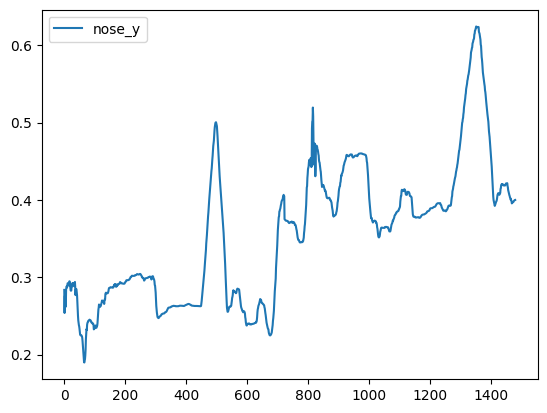

In [42]:
dataframe[['nose_y']].plot()